In [ ]:
'''
URJC / GIA / Aprendizaje Automático 1 / Curso 23-24
alfredo.cuesta@urjc.es
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

np.set_printoptions(precision=2)
pd.set_option("display.precision", 2)

# Análisis de Componentes Principales
**_Principal Component Analysis_ (PCA)**

Hemos aprendido a generar nuevas características en función de otras que ya teníamos.<br>
Sin embargo, no tenemos un modo **sistemático** de hacerlo. De momento es todo "artesano", en el sentido de que probamos con diferentes funciones como $\exp()$ o $\log()$ y, como mucho, añadimos características polinómicas.

La función más sencilla para combinar características es la **combinación lineal**.<br>
En una combinación lineal cada característica es ponderada por un coeficiente y después se suman todas.
> <u>Ejemplo</u>. &nbsp;&nbsp; Para tres características $\{x_1, x_2, x_3\},$ una combinación lineal sería $~z = c_1x_1 + c_2x_2 + c_3x_3~$, donde $\{c_1, c_2, c_3\}\in \mathbb{R}$ son los coeficientes que ponderan (es decir que dan importancia o peso) a cada característica respectivamente.

**PCA** es una técnica para **sustituir** con nuevas características mediante combinaciones lineales de las que tenemos inicialmente. <br>
El problema que tenemos que resolver es **cómo calcular los coeficientes**.

PCA es una técnica de reducción de dimensión. Por tanto es de esperar que las nuevas características que sustituyen a las originales sean (en total) menos.

### Notación
- Como ya era habitual, utilizaremos $~N~$ y $~D~$ para indicar el número de filas y de columnas de la tabla de datos original respectivamente.
- Utilizaremos $~d~$ para indicar el número de componentes principales que utilizamos para representar los ejemplos; es decir la dimensionalidad reducida a la que llevamos nuestro conjunto de datos. <br>
En el caso límite, tendremos la misma dimensionalidad: $~~~d\le D.$
- Utilizaremos $x_i^{(k)}$ para indicar la $i$-ésima característica del ejemplo $k$-ésimo.
- De manera similar, utilizaremos $z_j^{(k)}$ para indicar el $j$-ésimo componente principal del ejemplo $k$-ésimo.
- Recordar que los vectores son siempre vectores columna y que un ejemplo aislado es un vector de características. <br>
Sin embargo cuando representamos un conjunto de datos como una tabla, los ejemplos son sus filas. <br>
> ${\bf x}^{(i)} = [x_1^{(i)}, \ldots, x_D^{(i)}]^\top\quad\quad~~$ sería el ejemplo $i$-ésimo.<br>
> ${\bf X} = \left[
  \begin{array}{ccccccc}
    x_1^{(1)} & \ldots & x_D^{(1)} \\
    \vdots    & \ddots & \vdots  \\
    x_1^{(N)} & \ldots & x_D^{(N)}
  \end{array}
  \right] \quad $ sería la tabla de $N$ ejemplos de dimensión $D$.

En resumen, al aplicar PCA reducimos el número de columas de la tabla de datos, de $D$ a $d$.<br>
Las columnas del conjunto de datos original son "características" y por tanto se representan por la letra $x$.<br>
Las columnas del conjunto reducido son "componentes principales" y se representan por la letra $z$.


## Fundamento teórico

### Motivación

Observa la figura animada de abajo.

En ella hay un conjunto de ejemplos representados por puntos azules.

Cada uno de esos ejemplos tiene dos coordenadas. El ejemplo $i$-ésimo tendrá coordenadas $~~x_1^{(i)} \quad\text{y}\quad x_2^{(i)}$.

Esto se puede interpretar del siguiente modo:
- cada ejemplo es un vector del espacio vectorial generado por la base
  $~{\bf U} = \left\lbrace {\bf u}_1 = [1,0]^\top\quad,\quad {\bf u}_2 = [0,1]^\top \right\rbrace$
- el ejemplo $i$-ésimo es el vector que se construye con una combinación lineal de los vectores de la base, cuyos coeficientes son las coordenadas, es decir
$$ {\bf x}^{(i)} = (x_1^{(i)}) \cdot {\bf u}_1 + (x_2^{(i)}) \cdot {\bf u}_2
$$

      Ejemplo.
        Decir "el vector x=(3,4)" es lo mismo que decir
              "el vector x = (3)[1,0] + (4)[0,1]".      

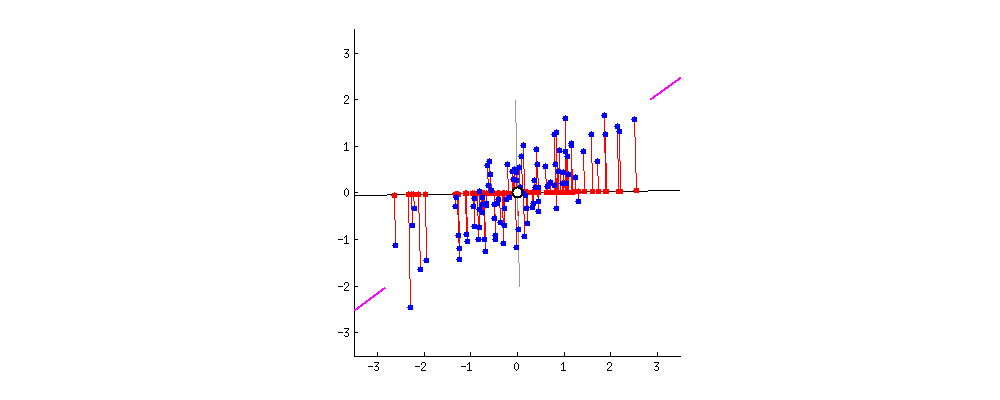

Al girar los ejes está cambiando la base, pero los vectores de la base siguen siendo ortogonales, es decir  ${\bf u}_i^\top {\bf u}_j = 0~$ para  $i\neq j$.


Además, según giran podemos ver que con la nueva base las coordenadas son diferentes, aunque no apreciamos ningún movimiento en los puntos azules.

      Ejemplo.
       Supón que ha girado 90 grados a la izquierda,
       entonces los vectores de la nueva base son u1 = [0,1] y u2 = [-1,0].    
       El punto x=(3,4) en esta nueva base está en x'=(4,-3)
        x' = (4)[0,1] + (-3)[-1,0]


**¿Y si utilizamos MENOS vectores de la base?**

>Entonces estamos proyectando los ejemplos en el subespacio generado por aquellos vectores de la base que sí utilizamos.
<br><br>
_En la figura esto sucede con los puntos rojos, que son la proyección de los ejemplos originales sobre ${\bf u}_1$, que es el vector que genera el subespacio de dimensión 1, es decir la recta sobre la que están las proyecciones en rojo._


**¿Cuál sería el mejor ángulo?**

> Al proyectar perdemos información, así que el mejor ángulo será aquel que **más** información conserve.
<br>
Dicho de otro modo, aquel en el que **menos** discrepancia haya entre el ejemplo original y el ejemplo proyectado.

Se trata de un problema de optimización (_como siempre en ML_)

### Previo
Necesitamos rescatar y refrescar dos conceptos de cursos anteriores
- Autovalores y Autovectores
- Matriz de covarianza


#### Autovectores y autovalores
**Definición y significado**

> Cuando multiplicamos una matriz cuadrada ${\bf A} \in \mathbb R ^{n\times n}$ por un vector ${\bf u} \in \mathbb R^n$ obtenemos otro vector del mismo tamaño que $\bf u$ pero, en general, diferente. <br>
Sin embargo hay ocasiones en que el vector obtenido es $\bf u$, pero multiplicado por un número $\lambda \in \mathbb R$ que lo hace más grande o más pequeño. <br>
Cuando  ocurre esto el vector $\bf u$ se llama **autovector** y el número $\lambda$ **autovalor**. Matemáticamente se expresa:
$${\bf A}{\bf u} = \lambda{\bf u}.$$

**Propiedades**
>- Una matriz cuadrada ${\bf A} \in \mathbb R ^{n\times n}$ tiene $~n~$ autovalores sólo si su determinante $|{\bf A}|\neq 0$.<br>
<small>Si la matriz no es cuadrada o no tiene determinante distinto de cero entonces **no** tiene autovalores.</small>
- Los autovalores no tienen por qué ser todos distintos.
- Sea ${\bf X} \in \mathbb R ^{n\times m}$ (por tanto NO cuadrada),
si $\lambda$ es autovalor de ${\bf X}^\top
{\bf X}$ también lo es de ${\bf X}
{\bf X}^\top$ <br>
>><small>
<u>Demostración</u><br>
Sean dos matrices $~{\bf A~}$ y ${~\bf B},~$  cuadradas y del mismo tamaño; tal que ambas tienen el autovalor $\lambda$.<br>
Sea $\bf u$ el autovalor de ${\bf A~}$ asociado a $\lambda$,
y sea $\bf v$ el autovalor de ${\bf B~}$ asociado a $\lambda$; es decir:
$${\bf A}{\bf u} = \lambda{\bf u} \quad\text{y}\quad {\bf B}{\bf v} = \lambda{\bf v}$$
Si ${\bf A}={\bf X}^\top{\bf X}$ entonces
$~{\bf X}^\top{\bf X}{\bf u} = \lambda{\bf u}.$<br>
Multiplicando por la izquierda por $\bf X$ tenemos
$~{\bf X}{\bf X}^\top{\bf X}{\bf u} = {\bf X}\lambda{\bf u} = \lambda{\bf X}{\bf u}.$<br>
Si al producto ${\bf X}{\bf X}^\top$ lo llamamos $\bf B,~$ y recordando que al multiplicar una matriz por un vector "cualquiera" se obtiene otro vector entonces podemos reescribir la última exprsión como
${\bf B}{\bf v} = \lambda{\bf v}.$<br>
En definitiva, $\lambda$ es autovalor tanto de $~{\bf A}={\bf X}^\top{\bf X}~$ como de $~{\bf B}={\bf X}{\bf X}^\top$.
</small>



#### Matriz de covarianza
**Definición**
> la covarianza de dos variables aleatorias $X$ e $Y$, de las cuales tenemos una población de $N$ muestras se define como
$$
\Sigma_{X,Y} = \mathbb E \big[ ({ X} - \mathbb E[X])^\top ({ Y} - \mathbb E[Y]) \big]_,
$$
siempre que la población se represente como vectores columna

**Aplicado a nuestro problema**
>- las variables aleatorias son dos atributos cualesquiera, $~x_i~$  y $~x_j~$, con $~i,j=1,2,\ldots,D$.
- el valor esperado se puede aproximar por el promedio, de tal modo que
$\mathbb E[x_i] \approx \frac{1}{N}\sum\nolimits_{k=1}^{N}x_i^{(k)}~, \forall i.$
<br>
Por tanto, si $~\mu_i~$ y $~\mu_j~$ son el promedio de la $i$-ésima y $j$-ésima  características respectivamente, entonces la covarianza entre ambas es
$$
\Sigma_{i,j} = \frac{1}{N} \sum\limits_{k=1}^{N}\left( (x_i^{(k)}-\mu_i) (x_j^{(k)}-\mu_j)  \right)
$$
     Ejemplo
    =========
    | x | y |  mu_x = 2
    |---|---|  mu_y = 3
    | 1 | 2 |  
    | 2 | 3 |  Cov(x,y) = 1/3 * [(1 - 2)(2 - 3) + (2 - 2)(3 - 3) + (3 - 2)(4 - 3)]
    | 3 | 4 |           = -2/3
>- Si las medias son cero, lo que ocurre cuando los atributos están estandarizados, entonces
$$
\Sigma_{i,j} = \frac{1}{N} \sum\limits_{k=1}^{N}\left( x_i^{(k)}\cdot x_j^{(k)}  \right) = x_i^\top x_j,
$$
donde recordamos que tanto $x_i$ como $x_j$ son dos características, es decir dos columnas de la matriz $\bf X$.
     Ejemplo
    =========
    | x  |  y |  mu_x = 0
    |----|----|  mu_y = 0
    | -1 | -1 |  
    |  0 | -2 |  Cov(x,y) = 1/3 * [ (-1)(-1) + (0)(-2) + (1)(3) ]
    |  1 |  3 |           = 1/3 ( x^t · y) = 4/3

**Cálculo eficiente**
>En vez de calcular la covarianza de cada par de características, calculamos en un solo paso la matriz de covarianza de la tabla $~\bf X~$ completa si:
1. Estandarizamos la tabla, de manera que la media de cada columna sea 0
2. Aplicamos la siguiente fórmula
$$
\Sigma = {\bf X}^\top{\bf X}.
$$

### Problema de optimización de componentes principales
En esta sección se plantea y resuelve el problema de optimización que resulta en el algoritmo para calcular los componentes principales de una tabla de datos.

#### Planteamiento
- Sea ${\bf U} = \left\lbrace{\bf u}_1, {\bf u}_2, \ldots, {\bf u}_D\right\rbrace$ la base ortonormal del espacio $\mathbb R ^D~$ que queremos encontrar.
- Los vectores $\bf x$ en esta base se representan por $\hat{\bf x}$ y tendrán unas coordenadas diferentes a sus coordenadas iniciales.
$$\hat{\bf x} = [z_1, z_2, \ldots, z_D]^\top = (z_1){\bf u}_1 + (z_2){\bf u}_2 + \cdots (z_D){\bf u}_D$$
El vector $\hat{\bf x}$ se llama **reconstrucción** de $\bf x$ en la base $\bf U$.
- Cada coordenada se calcula proyectando $\bf x$ sobre cada vector de la base ${\bf u}_i$, para $i=1,2,\ldots,D$.
$$z_i = {\bf x}^\top{\bf u}_i$$
- PERO si solo usamos $d < D$ vectores entonces $\hat{\bf x} \neq {\bf x}$, <br>
>en este caso $\hat{\bf x}$ es la proyección de ${\bf x}$ en el subespacio generado por la base ${\bf U}_d = \left\lbrace{\bf u}_1, {\bf u}_2, \ldots, {\bf u}_d\right\rbrace$.
- Sea $~~\varepsilon = \sum\limits_{k=d+1}^D z_k \cdot {\bf u}_k~~~$ el **residuo** de la reconstrucción; <br>
es decir las coordendas de la reconstrucción que "se quedan fuera" por usar solo $d$ dimensiones. <br> **Cuanto MENOR sea el residuo más parecida será la reconstrucción al original**<br>
<u>¡¡ Importante</u>:  El residuo es un vector !!

      Ejemplo.
       Sea p = (1, 0.2, 3)
       Si tuviera que proyectar este punto 3D sobre uno de los tres planos: XY, XZ o YZ,
       ¿sobre cuál obtendría un punto p' más parecido a p?
       - Si se proyecta en XY, p' = (1, 0.2) se queda a distancia 3 de p
       - Si se proyecta en XZ, p' = (1, 3)   se queda a distancia 0.2 de p
       - Si se proyecta en XY, p' = (0.2, 3) se queda a distancia 1 de p
       Solución: el plano XZ


#### Formalización
- El objetivo es **minimizar** el valor esperado de la norma-2 al cuadrado del residuo.
- ¿Qué podemos cambiar nosotros para que el residuo suba o baje?
$~\rightarrow~$ Los vectores de la base ${\bf U}.$<br>
Por tanto
$$
\begin{align}
\mathop{\arg\min}\limits_{\bf U}{\mathbb E}\Vert \varepsilon \Vert_2^2 &=
 \mathop{\arg\min}\limits_{\bf U}{\mathbb E}\big[\varepsilon^\top\varepsilon\big] \\ &=
\mathop{\arg\min}\limits_{\bf U}{\mathbb E}\left[\left(\sum\limits_{k=d+1}^D z_k {\bf u}_k\right)^\top\left(\sum\limits_{k=d+1}^D z_k {\bf u}_k\right)\right]\\ &=
\mathop{\arg\min}\limits_{\bf U} \sum\limits_{k=d+1}^D {\mathbb E}\left[z_k^\top z_k\right]
\end{align}
$$
- En la expresión de arriba hemos utilizado el hecho de que:
  -  $\bf U$ es una base ortonormal, es decir que ${\bf u}_i^\top {\bf u}_j = 0$ cuando $i\neq j$, y en caso contrario es $1$.
  - $\mathbb E [aX + b] = a \mathbb E [X]$ donde $X$ es una variable aleatoria y $a$ y $b$ son constantes.
- A continuación introducimos la definción de $z_k$
$$
\begin{align}
\mathbb E \left[ z_k^\top z_k \right] &=
\mathbb E \left[ \left( {\bf x}^\top{\bf u}_k \right)^\top \left( {\bf x}^\top{\bf u}_k \right) \right] =
\mathbb E \left[  {\bf u}_k^\top{\bf x} {\bf x}^\top{\bf u}_k  \right]
= {\bf u}_k^\top \mathbb E\left[ {\bf x}{\bf x}^\top \right] {\bf u}_k
\end{align}
$$
- Esto es para 1 ejemplo ${\bf x}$, que se representa como un vector columna.<br>
PERO si tenemos $N$ vectores en una tabla $~{\bf X}\in \mathbb R^{N\times D}~$, donde cada ejemplo es una fila, <br>podemos hacer todos a la vez calculando $~{\bf X}^\top{\bf X}.~$<br>
PERO si los datos de la tabla están estandarizados entonces
$$
\mathbb E \left[ {\bf X}^\top{\bf X} \right] = \Sigma.
$$
- En definitiva, tenemos que resolver el siguiente problema de optimización
$$
\left\lbrace
\begin{array}{l}
\mathop{\arg\min}\limits_{\bf U} \sum\limits_{k=d+1}^D {\bf u}_k^\top \Sigma {\bf u}_k  \\
\text{ sujeto a } ~ {\bf u}_k^\top{\bf u}_k = 1 ;~ k=d+1,\ldots,D
\end{array}
\right.
$$



####Solución

- Se ha planteado un problema de optimización cuadrática **con restricciones**.<br>
<small>_Esto significa que aquello que queremos optimizar aparece elevado al cuadrado, o en el caso de matrices, multiplicado por su traspuesta, y que no vale cualquier solución._</small>
- El mínimo se localiza haciendo la derivada de la función respecto de las variables objetivo:
$$
\left\lbrace
\begin{array}{l}
  \frac{\partial}{\partial{\bf u}_{d+1}} \left( {\bf u}_{d+1}^\top{\Sigma}{\bf u}_{d+1}\right) = 0 ;\text{ sujeto a }{\bf u}_{d+1}^\top{\bf u}_{d+1} = 1  \\
  \frac{\partial}{\partial{\bf u}_{d+2}} \left( {\bf u}_{d+2}^\top{\Sigma}{\bf u}_{d+2}\right) = 0 ;\text{ sujeto a }{\bf u}_{d+2}^\top{\bf u}_{d+2} = 1   \\
  \quad \vdots \\
  \frac{\partial}{\partial{\bf u}_{D}} \left( {\bf u}_{D}^\top{\Sigma}{\bf u}_{D}\right) = 0 ;\text{ sujeto a }{\bf u}_{D}^\top{\bf u}_{D} = 1   \\
\end{array}
\right.
$$
- Para resolverlo necesitamos recurrir al método de **multiplicadores de Lagrange**, que transforma nuestra optimización cuadrática en otra sin restricciones sobre $\bf u$.
- Este método introduce un multiplicador $\lambda_k \ge 0$ por cada restricción. <br>
De esta manera, y tomando una fila cualquiera de la expresión de arriba (son todas iguales salvo por el subíndice) tenemos el planteamiento _dual_:
$$
\mathop{\arg\min}\limits_{{\bf u}_k} \left( {\bf u}_k^\top{\Sigma}{\bf u}_k\right) - \lambda_k\left( {\bf u}_{k}^\top{\bf u}_{k} - 1 \right)
~,\quad k=d+1,\ldots,D.
$$
Y por tanto
$$
\frac{\partial}{\partial{\bf u}_k} \left( {\bf u}_k^\top{\Sigma}{\bf u}_k\right) - \lambda_k\left( {\bf u}_{k}^\top{\bf u}_{k} - 1 \right)  = 0,
$$
haciendo la derivada llegamos a
$$
{\Sigma}\cdot {\bf u}_{k} - \lambda_{k} \cdot {\bf u}_{k} = 0,
$$
es decir
$${{\Sigma}\cdot {\bf u}_{k} = \lambda_{k} \cdot {\bf u}_{k}}.$$
<br>
Por tanto, resolviendo el problema de autovalores y autovectores de ${\Sigma}$ obtenemos los vectores de la base buscada.

**Resumiendo,**$\quad$
calculando la matriz de covarianza de los datos $\Sigma$ y obteniendo sus autovalores y autovectores encontramos la base que minimiza el residuo.

#### Interpretación
- Dada una tabla de datos estandarizados, comenzamos calculando su matriz de covarianza $\Sigma$.
- A continuación obtenemos los autovalores y autovectores de $\Sigma$, y ordenamos los autovalores de mayor a menor. <br>
Asignamos $\lambda_1$ al mayor, $\lambda_2$ al siguiente, y así hasta $\lambda_D$ al menor de todos.<br>
De esta manera, ${\bf u}_k$ es el autovalor asociado a $\lambda_k$.
- Entonces,
$$
\mathop{\arg\min}\limits_{\bf U} \sum\limits_{k=d+1}^D {\bf u}_k^\top \Sigma {\bf u}_k  
=
\mathop{\arg\max}\limits_{\bf U} \sum\limits_{k=1}^d {\bf u}_k^\top \Sigma {\bf u}_k  
$$
es decir que, en vez de minimizar el residuo (lo que "se ha quedado fuera"), maximizamos la proyección (lo que "sí se ha usado"). <br>
Recordar que $\bf U$ es una base ortonormal, de modo que...<br>
__PCA encuentra como girar los ejes para proyectar los datos en $\mathbb R^d$ maximizando la varianza acumulada.__

# Ejemplo

Vamos a utilizar el conjunto de datos "Wine", que viene en la biblioteca Scikit-Learn
> _Estos datos son los resultados de un análisis químico de vinos cultivados en la misma región de Italia pero procedentes de tres cepas diferentes. Esos análisis determinaron las cantidades de 13 componentes presentes en cada uno de los tres tipos de vino._

In [ ]:
# ejemplo con el conjunto de datos "load_wine"

wine = load_wine()
wine_df = pd.DataFrame(wine.data, columns=wine.feature_names)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(wine_df)
wine_std = scaler.transform(wine_df)
print(wine_std.info())
wine_std.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,1.78e+02,1.78e+02,1.78e+02,1.78e+02,1.78e+02,1.78e+02,1.78e+02,1.78e+02,1.78e+02,1.78e+02,1.78e+02,1.78e+02,1.78e+02
mean,7.94e-15,3.59e-16,-4.07e-15,-7.98e-17,-7.98e-17,-3.99e-17,9.98e-16,-5.59e-16,-1.66e-15,-3.44e-16,1.64e-15,2.24e-15,-1.20e-16
std,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00
min,-2.43e+00,-1.43e+00,-3.68e+00,-2.67e+00,-2.09e+00,-2.11e+00,-1.70e+00,-1.87e+00,-2.07e+00,-1.63e+00,-2.09e+00,-1.90e+00,-1.49e+00
25%,-7.88e-01,-6.59e-01,-5.72e-01,-6.89e-01,-8.24e-01,-8.85e-01,-8.28e-01,-7.40e-01,-5.97e-01,-7.95e-01,-7.68e-01,-9.52e-01,-7.85e-01
50%,6.10e-02,-4.23e-01,-2.38e-02,1.52e-03,-1.22e-01,9.60e-02,1.06e-01,-1.76e-01,-6.29e-02,-1.59e-01,3.31e-02,2.38e-01,-2.34e-01
75%,8.36e-01,6.70e-01,6.98e-01,6.02e-01,5.10e-01,8.09e-01,8.49e-01,6.10e-01,6.29e-01,4.94e-01,7.13e-01,7.89e-01,7.58e-01
max,2.26e+00,3.11e+00,3.16e+00,3.15e+00,4.37e+00,2.54e+00,3.06e+00,2.40e+00,3.49e+00,3.44e+00,3.30e+00,1.96e+00,2.97e+00


El algoritmo de PCA en sklearn tiene la opción `n_components`.

Dándole un valor entero $n$ indicamos los $n$ primeros componentes principales.

La siguiente celda muestra el resultado con $n=2$.

In [ ]:
# ejemplo de PCA seleccionando directamente el número de componentes

n_components = 2

pca = PCA(n_components = n_components).set_output(transform="pandas")
pca.fit(wine_std)
df_pca = pca.transform(wine_std)

print('Tabla con los dos primeros componentes principales')
print(df_pca)

Tabla con los dos primeros componentes principales
     pca0  pca1
0    3.32 -1.44
1    2.21  0.33
2    2.52 -1.03
3    3.76 -2.76
4    1.01 -0.87
..    ...   ...
173 -3.37 -2.22
174 -2.60 -1.76
175 -2.68 -2.76
176 -2.39 -2.30
177 -3.21 -2.77

[178 rows x 2 columns]


En la siguiente celda se define la función `plot_PCA` para mostrar en un gráfico la varianza explicada por cada componente principal y la acumalada con cada uno que añadimos.

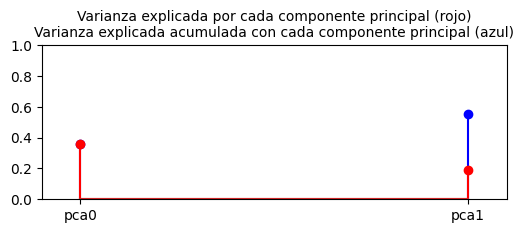

In [ ]:
def plot_PCA(pca):
  plt.stem(pca.explained_variance_ratio_.cumsum(),'b')
  plt.stem(pca.explained_variance_ratio_,'r')

  titleStr = 'Varianza explicada por cada componente principal (rojo)'
  titleStr = titleStr+'\n'
  titleStr = titleStr+'Varianza explicada acumulada con cada componente principal (azul)'
  plt.title(titleStr, fontsize=10)
  ax = plt.gca()
  ax.axis([-0.1,1.1,0,1])
  ax.set_xticks([i for i in range(pca.n_components_)])
  ax.set_xticklabels(["pca"+str(i) for i in range(pca.n_components_)])

  fig = plt.gcf()
  fig.set_size_inches(6,2)

  plt.show()

plot_PCA(pca)

Dándo un valor $n\in(0,1)$ a la opción `n_components` indicamos al algoritmo que debe tomar tantos componentes principales hasta que alcance el $n\%$ de la varianza acumulada explicada.

La siguiente celda muestra el resultado con $n=0.9$, o sea el $90\%$. <br>
Podemos ver que ha necesitado los 8 primeros componentes principales.

Tabla con los componentes principales hasta explicar el 90.0% de la varianza
     pca0  pca1  pca2  pca3  pca4  pca5      pca6  pca7
0    3.32 -1.44 -0.17 -0.22  0.69 -0.22  5.96e-01  0.07
1    2.21  0.33 -2.03 -0.29 -0.26 -0.93  5.38e-02  1.02
2    2.52 -1.03  0.98  0.72 -0.25  0.55  4.24e-01 -0.34
3    3.76 -2.76 -0.18  0.57 -0.31  0.11 -3.83e-01  0.64
4    1.01 -0.87  2.03 -0.41  0.30 -0.41  4.44e-01  0.42
..    ...   ...   ...   ...   ...   ...       ...   ...
173 -3.37 -2.22 -0.34  1.06 -0.57 -1.11  9.58e-01 -0.15
174 -2.60 -1.76  0.21  0.35  0.26 -0.03  1.47e-01 -0.55
175 -2.68 -2.76 -0.94  0.31  1.27  0.27  6.79e-01  0.05
176 -2.39 -2.30 -0.55 -0.69  0.81  1.18  6.34e-01  0.39
177 -3.21 -2.77  1.01  0.60 -0.90  0.30  5.74e-03 -0.29

[178 rows x 8 columns]


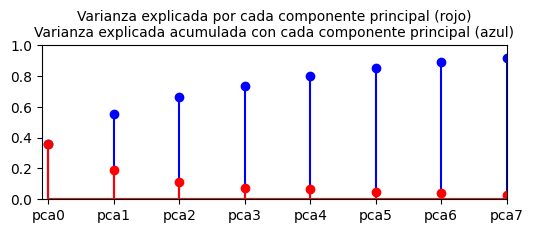

In [ ]:
# ejemplo de PCA seleccionando directamente el ratio de varianza explicada total

n_components = .9

pca = PCA(n_components = n_components).set_output(transform="pandas")
pca.fit(wine_std)
df_pca = pca.transform(wine_std)

print(f'Tabla con los componentes principales hasta explicar el {n_components*100}% de la varianza')
print(df_pca)

plot_PCA(pca)

Finalmente vamos a comprobar que la teoría explicada realmente funciona.<br>
Por un lado tenemos la tabla de valores $\bf X$.<br>
Por otro lado tenemos la base ${\bf U}_d$; donde vamos a utilizar la última celda de código, con $d=8$, para mostrar como calcular la proyección.

La proyección de $\bf X$ en la base ${\bf U}_d$ es $~{\bf X}{\bf U}_d~$ ya que los ejemplos de $\bf X$ van en filas y los autovectores de $\Sigma$ son las columnas de $\bf U$.

PERO en el objeto `pca` los $d$ autovectores  de $\Sigma$ que hemos usado (o sea los asociados con los primeros $d$ autovalores) se almacenan en filas, por lo que debemos trasponerlos para que estén en columnas.

In [ ]:
X = wine_std.values     #<- pasamos el df a un numpy array
print(f'X tiene {X.shape[0]} ejemplos de dimensión {X.shape[1]}')

#- 2. Obtenemos Ud
Ud =  pca.components_   #<- Ya es un numpy array
print(f'\nUd tiene dimensión {Ud.shape}:')
print(f'  - {Ud.shape[0]} es el número de vectores que vamos a utilizar')
print(f'  - {Ud.shape[1]} es la dimensión de cada vector')
print(f'    Obviamente coincide con la dimensión original')
print(f'\nPor tanto si quiero proyectar X en el espacio generado por Ud')
print(f'Ud debe tener sus vectores en columnas')
print(f'Ud.T = \n{Ud.T}')

#- 3. Realizamos la proyección
Z = np.matmul( X ,Ud.T )

#- Z debería coincidir con los valores de df_pca
print(f'\n Z =\n{Z}\n\ndf_pca =\n{df_pca}')
print('\n¡Efectivamente, Z y df_pca son iguales!')


X tiene 178 ejemplos de dimensión 13

Ud tiene dimensión (8, 13):
  - 8 es el número de vectores que vamos a utilizar
  - 13 es la dimensión de cada vector
    Obviamente coincide con la dimensión original

Por tanto si quiero proyectar X en el espacio generado por Ud
Ud debe tener sus vectores en columnas
Ud.T = 
[[ 0.14 -0.48 -0.21 -0.02 -0.27 -0.21 -0.06 -0.4 ]
 [-0.25 -0.22  0.09  0.54  0.04 -0.54  0.42 -0.07]
 [-0.   -0.32  0.63 -0.21 -0.14 -0.15 -0.15  0.17]
 [-0.24  0.01  0.61  0.06  0.07  0.1  -0.29 -0.43]
 [ 0.14 -0.3   0.13 -0.35  0.73 -0.04  0.32  0.16]
 [ 0.39 -0.07  0.15  0.2  -0.15  0.08 -0.03  0.41]
 [ 0.42  0.    0.15  0.15 -0.11  0.02 -0.06  0.19]
 [-0.3  -0.03  0.17 -0.2  -0.5   0.26  0.6   0.23]
 [ 0.31 -0.04  0.15  0.4   0.14  0.53  0.37 -0.37]
 [-0.09 -0.53 -0.14  0.07 -0.08  0.42 -0.23  0.03]
 [ 0.3   0.28  0.09 -0.43 -0.17 -0.11  0.23 -0.44]
 [ 0.38  0.16  0.17  0.18 -0.1  -0.27 -0.04  0.08]
 [ 0.29 -0.36 -0.13 -0.23 -0.16 -0.12  0.08 -0.12]]

 Z =
[[ 3.32 -1.44 

**IMPORTANTE**

La tabla $\bf Z$ de ejemplos proyectados con PCA se obtiene de la multiplicación de $\bf X$ por una matriz.

Por tanto cada elemento de cada ejemplo de $\bf Z$ es una **combinación lineal** de las características de $\bf X$.

# Ejercicios

Realiza los siguientes pasos:
1. Separa el conjunto de datos "load_wine" en Entrenamiento (90%) y Test (10%)<br>
A partir de ese momento utiliza sólo el conjunto de entrenamiento.
2. Aumenta la dimensionalidad
3. Haz un filtrado de características
4. Haz una reducción a 3 componentes principales<br>
  ¿Cuál es el ratio de varianza explicada por estos 3 componentes principales?


Razona la respuesta a la siguiente pregunta. ¿Qué habría que hacer antes: filtrado por varianza o PCA?